In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from geopy.geocoders import Nominatim
import time
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from IPython.display import IFrame
from IPython.display import display

#Load the delivery data into 2 different data frames for each year
file_path = 'Data Deliveries.xlsx'
df_2024 = pd.read_excel(file_path, sheet_name='2024')
df_2025 = pd.read_excel(file_path, sheet_name='2025')


# Weekly Deliveries

We get the total number of deliveries for each week. Below, we are taking the 2024 and 2025 data. We can compare to see if the total number of deliveries during the same respective weeks have increased or decreased. This can help us see current trends and help us with scheduling.

In [10]:
def getWeeklyDeliveries():

    df = pd.concat([df_2024,df_2025], ignore_index=True)

    # Convert Date
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    # Extract year, week number, and start of week
    df['Year'] = df['Date'].dt.year
    df['Week_Num'] = df['Date'].dt.isocalendar().week
    df['Week_Start'] = df['Date'] - pd.to_timedelta(df['Date'].dt.dayofweek, unit='d')  # Start on Sunday

    # Extract month from Week_Start (ensures 1 value per week)
    df['Month'] = df['Week_Start'].dt.strftime('%B')

    # Count weekly deliveries
    weekly_counts = df.groupby(['Year', 'Week_Num']).size().reset_index(name='Deliveries')

    # Create a consistent `Week_Num -> Month` map using earliest week from any year
    month_map = df.groupby('Week_Num')['Month'].first().reset_index()
    df['Year'] = df['Year'].astype(int) #convert year to int from float
    # Pivot the delivery data
    pivot = weekly_counts.pivot(index='Week_Num', columns='Year', values='Deliveries')
    pivot.columns = [f'{col} Deliveries' for col in pivot.columns]
    pivot = pivot.reset_index()

    # Merge in Month label (no duplicates now)
    pivot = pivot.merge(month_map, on='Week_Num', how='left')

    # Reorder columns
    cols = ['Week_Num', 'Month'] + [col for col in pivot.columns if 'Deliveries' in col]
    pivot = pivot[cols]

    # Fill missing weeks with 0
    pivot = pivot.fillna(0).astype({col: 'int' for col in pivot.columns if 'Deliveries' in col})
    
    return pivot

getWeeklyDeliveries()

,Week_Num,Month,2024 Deliveries,2025 Deliveries
0,9,February,30,53
1,10,March,184,151
2,11,March,211,170
3,12,March,204,159
4,13,March,175,186
5,14,April,193,144
6,15,April,191,166
7,16,April,212,174
8,17,April,189,152
9,18,April,64,167


# Plotting The Trends

We plot the trends comparing 2024 vs 2025. As the comparison shows that the deliveries are down in comparison to the previous year. This can be due to a numerous of reasons such as economic factors with interest rates rising, inflation or new competitors opening up.

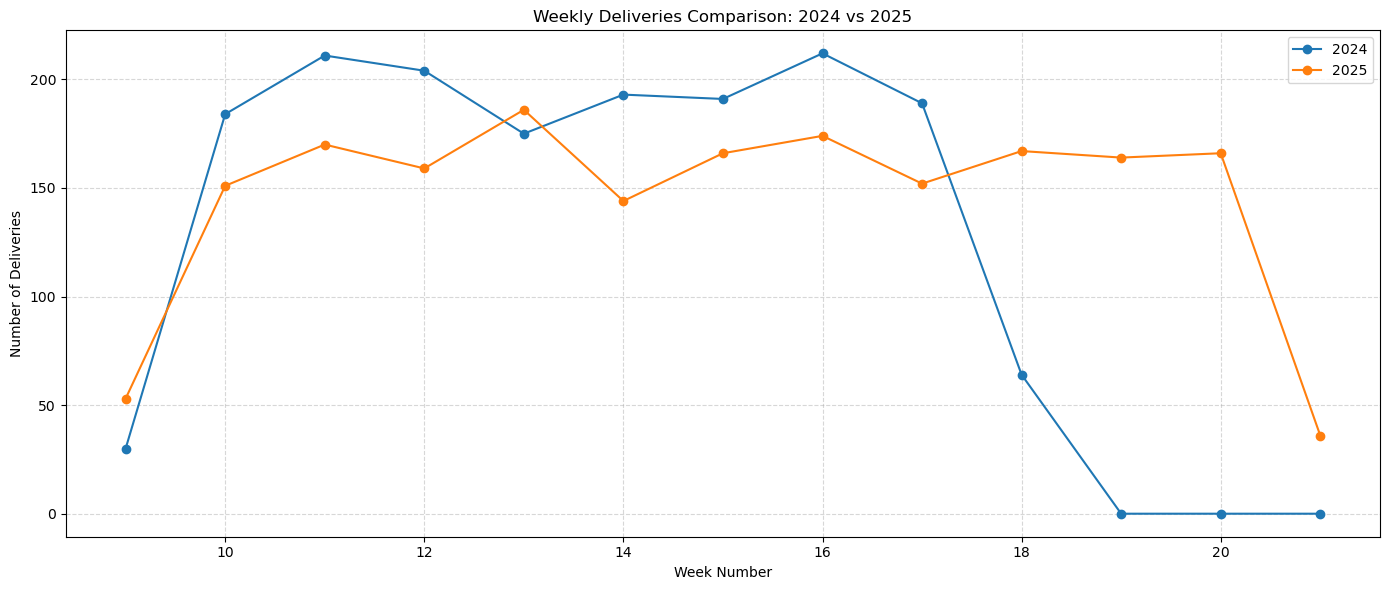

In [15]:
# Plot setup
pivot = getWeeklyDeliveries()
plt.figure(figsize=(14, 6))
plt.plot(pivot['Week_Num'], pivot['2024 Deliveries'], label='2024', marker='o')
plt.plot(pivot['Week_Num'], pivot['2025 Deliveries'], label='2025', marker='o')

plt.title('Weekly Deliveries Comparison: 2024 vs 2025')
plt.xlabel('Week Number')
plt.ylabel('Number of Deliveries')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()



# Generate Heat Map

Lets generate a Heat Map of the deliveries for a specified week. The will let us know which areas of the city the customers are ordering in. This will also let us know if certain areas need more promotional campaigns run or if a promotional campaign succeeded. It will help us budget for things like flyering. 

In [30]:
def generateHeatMap(start_of_week):
    
    df = df_2025
    df['Date'] = pd.to_datetime(df['Date'])

    start_date = pd.to_datetime(start_of_week)
    end_date = start_date + timedelta(days=6)

    df_week = df[(df['Date'] >= start_date) & (df['Date'] <= end_date) ]

    addresses = list(df_week['Address'])

    locations = get_locations(addresses)

    df_locations = pd.DataFrame(locations)
    df_locations = df_locations.rename(columns={0:'Address',1:'latitude',2:'longitude'})
    
    #merge the latitude and longitude
    df_week = df_week.merge(df_locations,on='Address',how='left')
    df_week = df_week.dropna(subset=['latitude', 'longitude'])

    map_center = [df_week['latitude'].mean(),df_week['longitude'].mean()]

    m = folium.Map(location=map_center, zoom_start=12)

    #generate heatmap
    heat_data = df_week[['latitude','longitude']]
    HeatMap(heat_data).add_to(m)

    m.save("delivery_heatmap.html")

#gets latitude and longitude of the address list
def get_locations(addresses):
    
    geolocator = Nominatim(user_agent="address_mapper")
    locations = []
    for address in addresses:
        try:
            location = geolocator.geocode(address)
            if location:
                locations.append((address, location.latitude, location.longitude))
        except Exception as e:
            continue #continue if address cannot be found
            #print(f"Error geocdoing {address}: {e}")
            
        time.sleep(2) #give a 2 second break inbetween api calls so we dont go over the limit of api
        
    return locations

generateHeatMap("2025-05-17")

# Heat Map

As you see the following heat map is generated. As you can see that deliveries occurred only in a small section of the city. There are concentrated areas where the majority of the deliveries occured and quite a large section where there were none. I would compare this heat map to where promotional campaigns (such as flyers) were run to see if they were a success. As well I would see the areas where little to no deliveries occured to focus on more flyering in those areas.

In [5]:
IFrame(src='delivery_heatmap.html',width=700,height=500)

# Inactive Customers 

We also want to find out inactive customers who have not ordered from us in specified amount of time. This will help us with targeting those customers with perhaps special offers to get them to order again. We have decided to get all customers who have not ordered from us in the past 6 months. As well as we have decided we want customers who had ordered more then once before but now have not. We save the addresses into an excel file as well as the customers average ticket price. This will help us target what kind of promotion we want to offer the customer. For example, if the customer average ticket was over $70 dollars, we may want to include a larger discount to entice them to order again as they are likely ordering for a family. 

In [7]:
#get inactive customers that have not ordered in the last 6 months
def getInactiveCustomers():
    '''
        Gets the inactive customers that have not ordered in the last 6 months
    '''
    # Combine both DataFrames
    df = pd.concat([df_2024, df_2025], ignore_index=True)
    # Ensure 'date' column is datetime type
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Remove any rows where date could not be parsed
    df = df.dropna(subset=['Date'])

    # Calculate the date 6 months ago from today
    six_months_ago = datetime.now() - pd.DateOffset(months=6)

    # Get the most recent order date per address
    last_order_per_address = df.groupby('Address')['Date'].max().reset_index()

    # Find addresses where the last order was more than 6 months ago
    inactive_customers = last_order_per_address[last_order_per_address['Date'] < six_months_ago]

    # Merge with original data to get full order history for inactive customers
    merged = pd.merge(inactive_customers[['Address']],df, on='Address',how='left')
    
    # Calculate order counts per address
    order_counts = merged.groupby('Address').size().reset_index(name='order_count')

    # Filter to only those customers who have ordered more than once
    multi_order_customers = order_counts[order_counts['order_count'] > 1]
    
    # Calculate average ticket price for these multi-order inactive customers
    avg_ticket_price = merged[merged['Address'].isin(multi_order_customers['Address'])] \
                    .groupby('Address')['Amount'].mean().reset_index().rename(columns={'Amount': 'avg_ticket_price'})
    

    inactive_customers = pd.merge(avg_ticket_price, last_order_per_address, on='Address')

    #save the inactive customers to excel file
    inactive_customers.to_excel('inactive_customers.xlsx', index=False)

getInactiveCustomers()

# Map Inactive Customers

We map the inactive customers to see if there a pattern of where customers have stopped ordering. This can help us identify the impact of perhaps new competitors opening up in certain areas.  

In [31]:
def mapInactiveCustomers():
    '''
        Map the inactive customers to see a visual representation
    '''
    inactive_customers = pd.read_excel('inactive_customers.xlsx')
    addresses = list(inactive_customers['Address'])

    locations = get_locations(addresses)
    
    if locations:
        avg_lat = sum(lat for _, lat, _ in locations) / len(locations)
        avg_lon = sum(lon for _,_, lon in locations) / len(locations)
        m = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)
    
        #add a marker at the specified addresses 
        for addr, lat, lon in locations:
            folium.Marker(location=[lat,lon], popup=addr).add_to(m)
        m.save("Inactive Customers.html")
        print("Map saved as Inactive Customers.html")
    else:
        print("No locations to map.")

mapInactiveCustomers()
IFrame(src='Inactive Customers.html',width=700,height=700)

Map saved as Inactive Customers.html


# Churn Prediction (Random Forest)

We now do a churn prediction to see which customers are likely to stop ordering. We will try identify at risk customers to preemptively take measures to stop them from churning. It will give each customer a probability score of churning. If the score is .6 or above, the customer is likley to churn. The customer churn probabilities are outputed to an excel file. 

We also print out the classification report. The classification report is how well our model is performing. 

|Metric	  | Meaning
|:--------|:-------------------------------------------------------------------------------------|
|Precision|	Out of all the customers the model predicted would churn, how many actually did?     |
|Recall	  | Out of all customers who actually churned, how many did the model correctly identify?|
|F1-score |	Harmonic mean of precision and recall — balances the two                             |
|Support  |	The number of actual instances in each class (e.g., how many churned)                |

Class 0 is how many did not churn. Class 1 is how many churned. 


The ROC AUC score ranges between 0 to 1. It tells you how well the model can separate churners from non-churners based on probability. In our case below, the model gives higher probabilities to all churners than to non-churners. This means it is the perfect ranking -> ROC AUC = 1.0. 

The score table is as follows:

|Score |	Meaning                                    |
|:-----|:----------------------------------------------|
|1.0   |    Perfect separation — ideal model           |
|0.95  |	Excellent — almost always right            |
|0.85  |	Very good — ranks most churners correctly  |
|0.70  |	Fair — helpful, but room for improvement   |
|0.50  |	No skill — same as random guessing         |
|< 0.50|	Worse than guessing — probably inverted    |


In [25]:
def time_to_seconds(t):
    '''
        Convert time (ex, 14:30:00) into seconds since midnight

        Params: 
            The time 
        
        Returns:
            the seconds since midnight
    '''
    if pd.isnull(t):
        return None
    return t.hour * 3600 + t.minute * 60 + t.second


def customerRetention():
    '''
        Uses supervised machine learning (Random Forest Model) to find the likelihood of customer reordering
    '''
    df = pd.concat([df_2024,df_2025], ignore_index=True)
    # Ensure 'date' column is datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])

    # Use April 1, 2025 as reference point
    reference_date = pd.Timestamp('2025-04-01')
    six_months_ago = reference_date - pd.DateOffset(months=6)

    df['time_in_seconds'] = df['Time'].apply(time_to_seconds)

    # Group by customer (address)
    group = df.groupby('Address').agg({
        'Date': ['min', 'max', 'count'],
        'Amount': 'mean',
        'Channel': lambda x: x.value_counts().to_dict(),
        'time_in_seconds': 'mean'
    })

    # Flatten column names
    group.columns = ['first_order', 'last_order', 'total_orders', 'avg_order_amount', 'order_channels', 'avg_order_time']
    group.reset_index(inplace=True)

    # Add days since last order
    group['days_since_last_order'] = (reference_date - group['last_order']).dt.days

    # Create churn label: 1 = churned (no order in last 6 months)       
    group['churn'] = (group['last_order'] < six_months_ago).astype(int)

    # Expand order channels into separate columns
    channels_df = pd.json_normalize(group['order_channels'])
    group = pd.concat([group, channels_df.fillna(0)], axis=1)

    # Final features
    features = ['total_orders', 'avg_order_amount', 'days_since_last_order', 'avg_order_time']
    features += [col for col in ['POS', 'call Center', 'web', 'mobile'] if col in group.columns]

    # Drop rows with missing data in selected features
    X = group[features].fillna(0)
    y = group['churn']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Train Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate model
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

    # Predict churn probability for all customers
    group['churn_probability'] = model.predict_proba(X_scaled)[:, 1]
    group['churn_prediction'] = (group['churn_probability'] >= 0.5).astype(int)

    # Save to Excel
    group[['Address', 'total_orders', 'avg_order_amount', 'days_since_last_order',
        'churn_probability', 'churn_prediction']].to_excel('churn_model_output.xlsx', index=False)

    print("Churn predictions saved to 'churn_model_output.xlsx'")

customerRetention()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       217
           1       1.00      1.00      1.00       105

    accuracy                           1.00       322
   macro avg       1.00      1.00      1.00       322
weighted avg       1.00      1.00      1.00       322

ROC AUC Score: 1.0
Churn predictions saved to 'churn_model_output.xlsx'
